In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from collections import defaultdict
from sklearn.linear_model import LinearRegression

sns.set_theme(palette="bright", style="whitegrid")
matplotlib.rcParams['font.serif'] = "cmb10"
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True

In [3]:
def read_res(path):
    data = defaultdict(list)
    sizes = []
    searched = []
    found = []
    time = 0
    query_time = 0
    rss = 0
    threads = 1
    ds_type = None
    with open(path) as in_f:
        for line in in_f:
            if "CBL/target/release" in line:
                ds_type = "CBL"
                threads = 1
            elif "bufboss/bin/" in line:
                ds_type = "Bufboss"
                threads = 1
            elif "bifrost/build/bin" in line:
                ds_type = "Bifrost"
            elif "Buffered_SBWT" in line:
                ds_type = "BSBWT"
            elif line.startswith("# query time"):
                query_time = int(line.split()[-1]) / 1000000000
            elif "Time for all queries" in line:
                query_time = float(line.split()[-2])
            elif line.startswith("Query time ns:"):
                query_time = int(line.split()[-1]) / 1000000000
            elif "maxresident" in line:
                for field in line.split():
                    if "elapsed" in field:
                        f_s = field[:-7].split(':')
                        time = int(f_s[-2]) * 60 + float(f_s[-1])
                        if len(f_s) > 2:
                            time += int(f_s[0]) * 60 * 60
                    elif "maxresident" in field:
                        rss = int(field[:-13])
                        rss /= 1024
                        if ds_type == "Bifrost":
                            data[f"{ds_type}-{threads}"].append((time, rss, query_time))
                        else:
                            data[ds_type].append((time, rss, query_time))
            elif line.startswith("Saw "):
                elems = int(line.split()[1])
                searched.append(elems)
            elif line.startswith("matched"):
                ss = line.split()
                query_time = float(ss[-2]) / 1000
                elems = int(ss[1])
                found.append(elems)
            elif "with " in line and "31-mers" in line:
                elems = int(line.split()[1]) // 2
                sizes.append(elems)
            elif line.startswith("threads"):
                threads = 32
    return {
        "size": sizes, 
        "searched": searched,
        "found": found,
        "data": data
    }

In [4]:
def plot_time_and_space(res, title, name=None):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    for k, v in res["data"].items():
        plt.plot(res["size"], [vv[2] * 1000**3 / s for vv, s in zip(v, res["searched"])], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Index size (k-mers)")
    plt.ylabel("Query time (ns / k-mer)")
    plt.legend()
    plt.title("query time")
    #a, b = plt.ylim()
    #plt.ylim(10, b)
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.subplot(1, 2, 2)
    for k, v in res["data"].items():
        plt.plot(res["size"], [vv[1] * 1024**2 * 8 / s for vv, s in zip(v, res["size"])], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Index size (k-mers)")
    plt.ylabel("RSS (bits / k-mer)")
    plt.legend()
    plt.title("memory efficiency")
    a, b = plt.ylim()
    plt.ylim(10, b)
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.suptitle(title)
    if name is not None:
        plt.savefig(name, bbox_inches="tight")
    plt.show()

In [5]:
def plot_total_time_and_space(res, title, name=None):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    for k, v in res["data"].items():
        plt.plot(res["size"], [vv[0] for vv in v], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Index size (k-mers)")
    plt.ylabel("Query time (s)")
    plt.legend()
    plt.title("query time total")
    #a, b = plt.ylim()
    #plt.ylim(10, b)
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.subplot(1, 2, 2)
    for k, v in res["data"].items():
        plt.plot(res["size"], [vv[1] * 1024**2 for vv in v], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Index size (k-mers)")
    plt.ylabel("RSS (bytes)")
    plt.legend()
    plt.title("RSS")
    #a, b = plt.ylim()
    #plt.ylim(10, b)
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.suptitle(title)
    if name is not None:
        plt.savefig(name, bbox_inches="tight")
    plt.show()

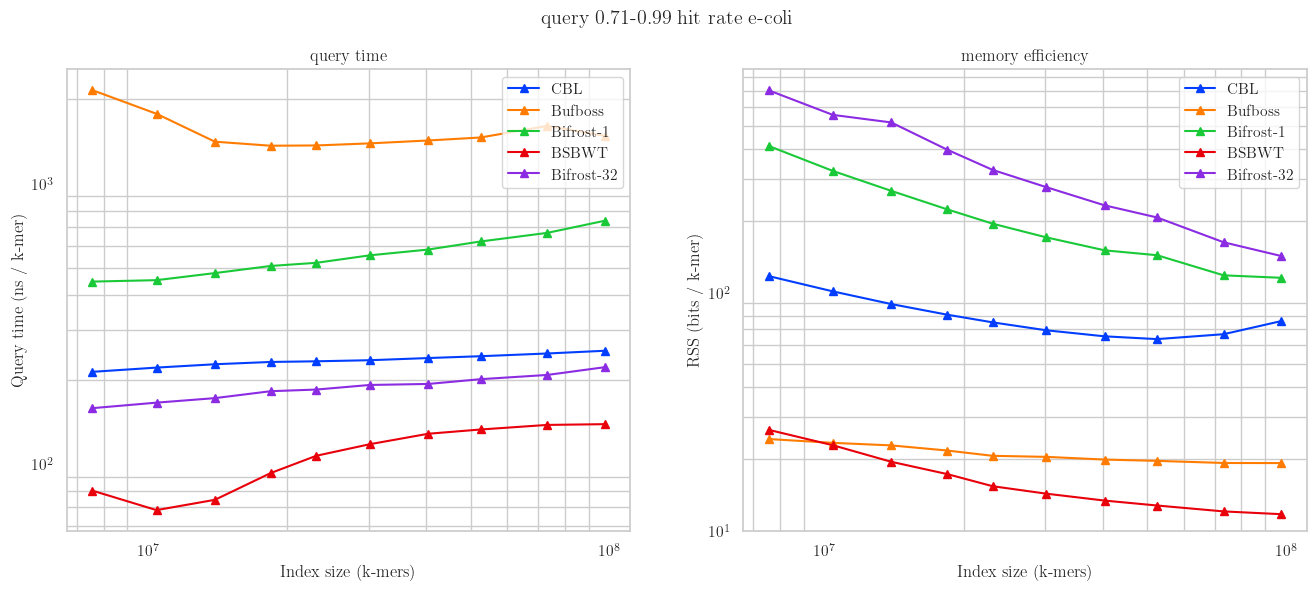

In [7]:
coli_res = read_res("../bbb_res/query_coli.txt")
h_r = [b / a for a, b in zip(coli_res["searched"], coli_res["found"])]
plot_time_and_space(coli_res, f"query {h_r[0]:.2}-{h_r[-1]:.2} hit rate e-coli", "query_e-coli_mixed.pdf")

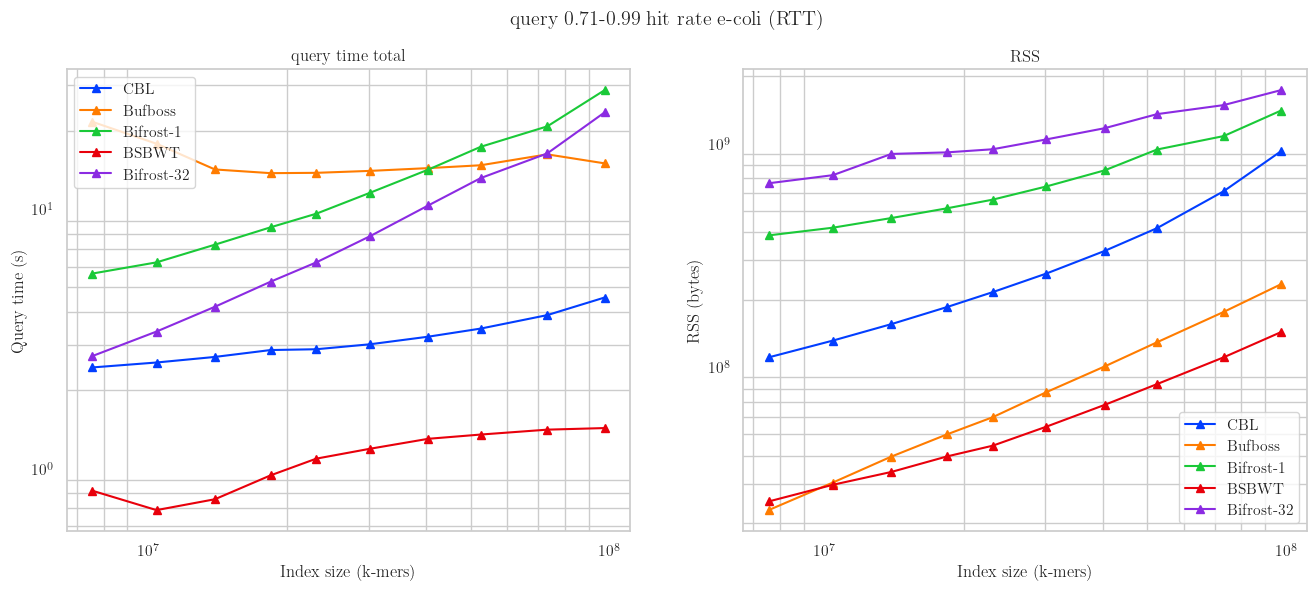

In [9]:
plot_total_time_and_space(coli_res, f"query {h_r[0]:.2}-{h_r[-1]:.2} hit rate e-coli (RTT)", "query_e-coli_mixed_RTT.pdf")

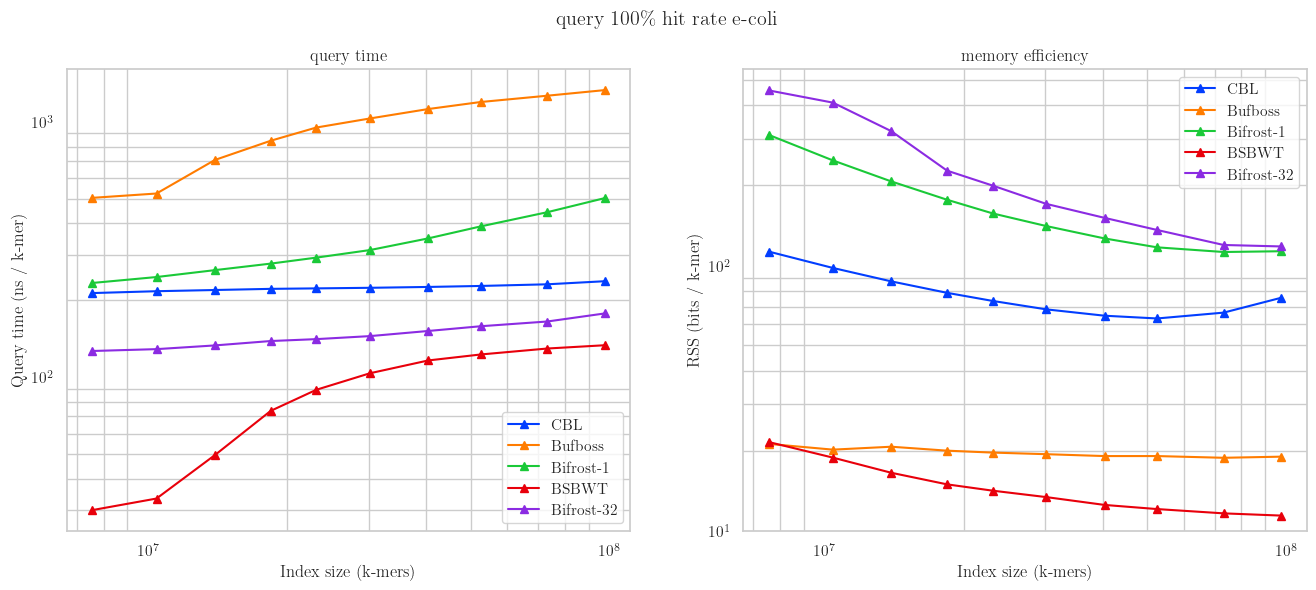

In [8]:
coli_res_pos = read_res("../bbb_res/query_coli_pos.txt")
h_r = [b / a for a, b in zip(coli_res_pos["searched"], coli_res_pos["found"])]
plot_time_and_space(coli_res_pos, f"query 100\\% hit rate e-coli", "query_e-coli_pos.pdf")

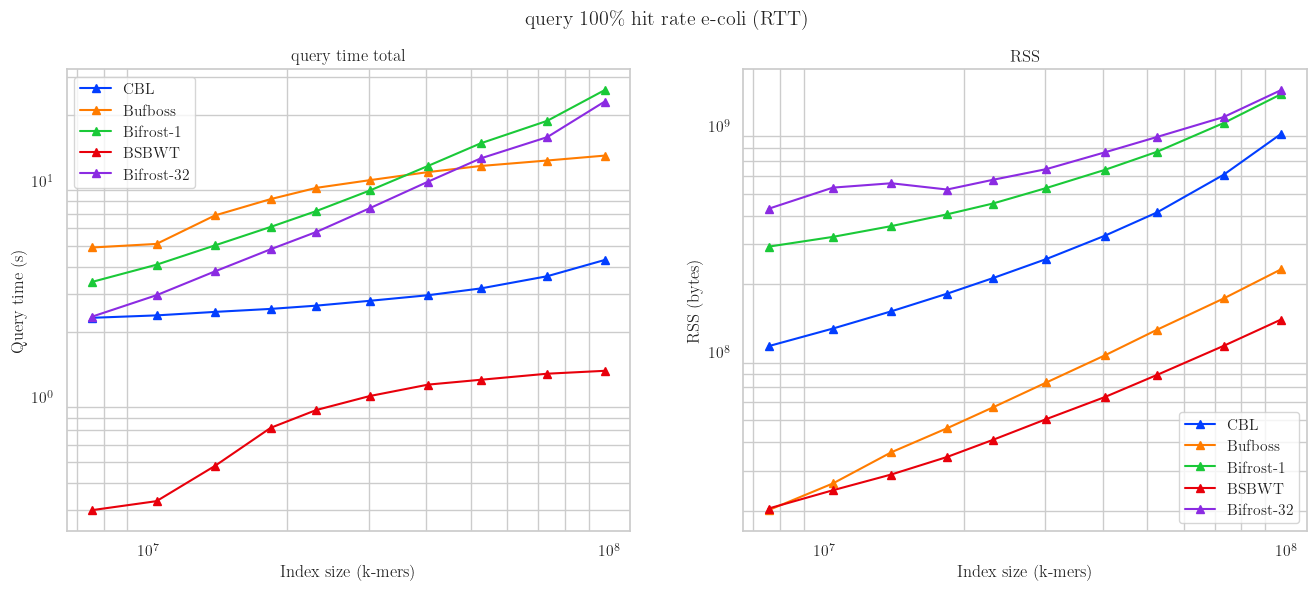

In [11]:
plot_total_time_and_space(coli_res_pos, f"query 100\\% hit rate e-coli (RTT)", "query_e-coli_pos_RTT.pdf")

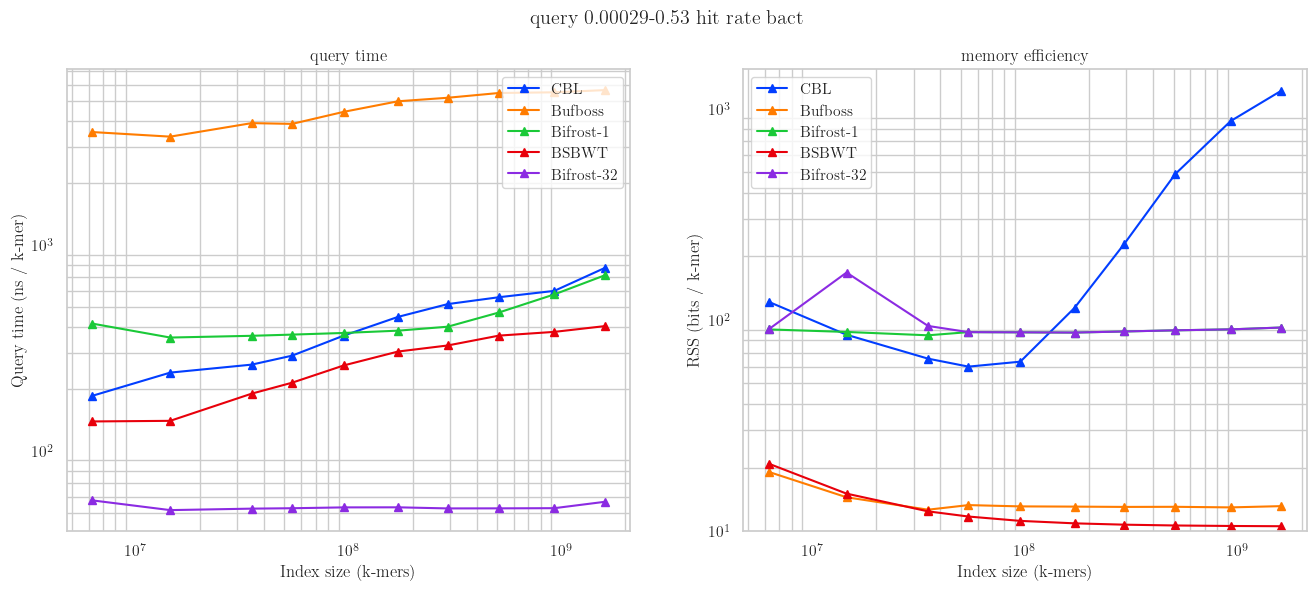

In [9]:
bact_res = read_res("../bbb_res/query_bact.txt")
h_r = [b / a for a, b in zip(bact_res["searched"], bact_res["found"])]
plot_time_and_space(bact_res, f"query {h_r[0]:.2}-{h_r[-1]:.2} hit rate bact", "query_bact_mixed.pdf")

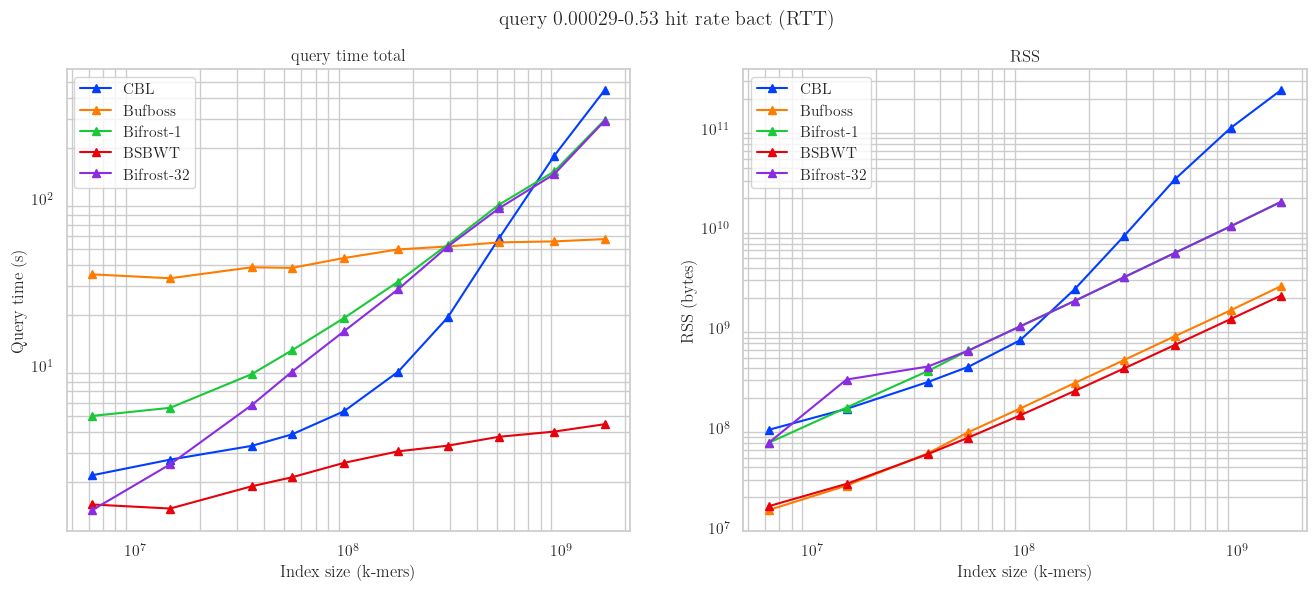

In [13]:
plot_total_time_and_space(bact_res, f"query {h_r[0]:.2}-{h_r[-1]:.2} hit rate bact (RTT)", "query_bact_mixed_RTT.pdf")

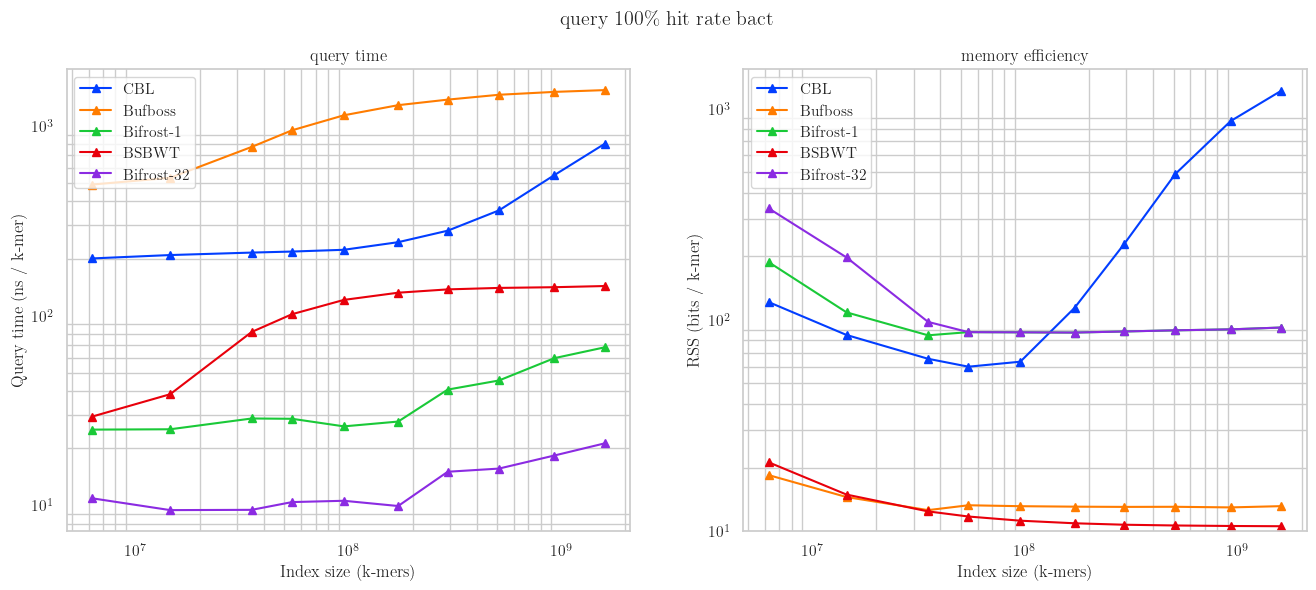

In [10]:
bact_res_pos = read_res("../bbb_res/query_bact_pos.txt")
h_r = [b / a for a, b in zip(bact_res_pos["searched"], bact_res_pos["found"])]
plot_time_and_space(bact_res_pos, "query 100\\% hit rate bact", "query_bact_pos.pdf")

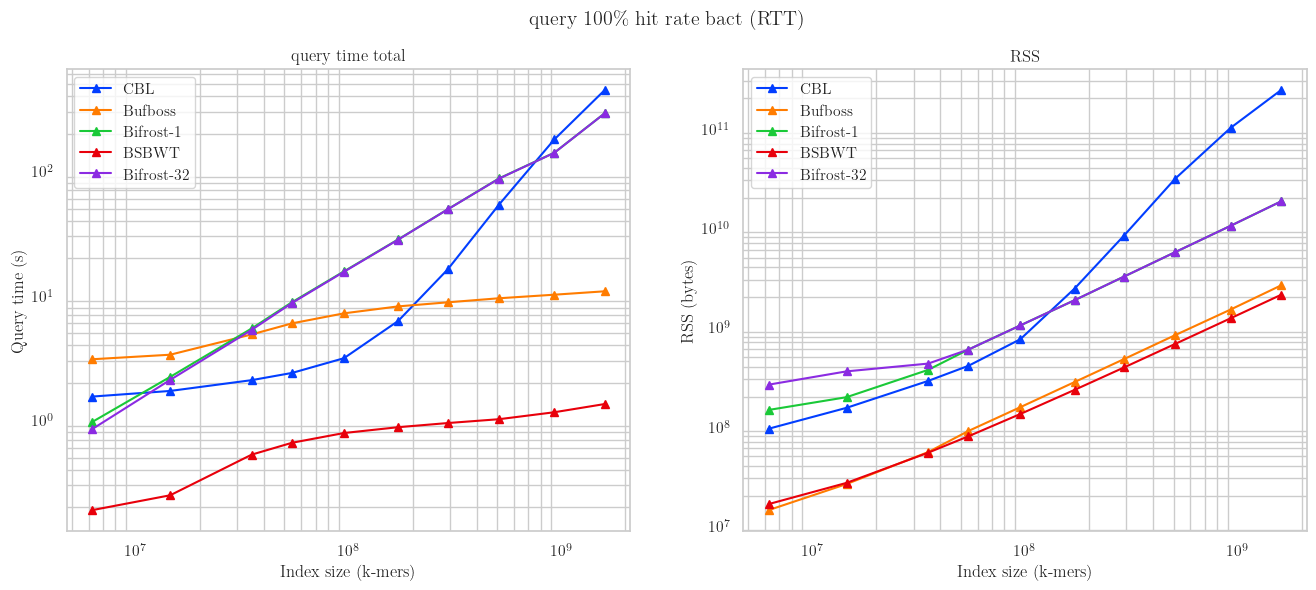

In [17]:
plot_total_time_and_space(bact_res_pos, f"query 100\\% hit rate bact (RTT)", "query_bact_pos_RTT.pdf")

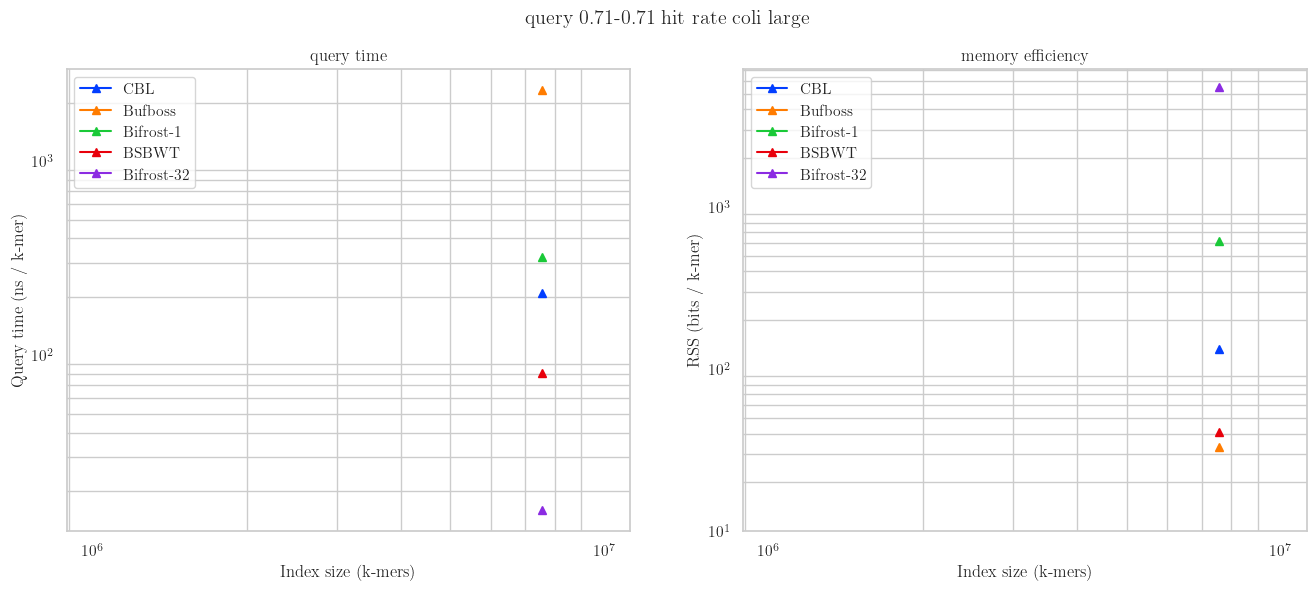

In [6]:
coli_res_large = read_res("../bbb_res/query_coli_big.txt")
h_r = [b / a for a, b in zip(coli_res_large["searched"], coli_res_large["found"])]
plot_time_and_space(coli_res_large, f"query {h_r[0]:.2}-{h_r[-1]:.2} hit rate coli large", "query_coli_big.pdf")

In [23]:
dss = [coli_res, coli_res_pos, bact_res, bact_res_pos]
dsn = ["coli", "coli pos", "bact", "bact pos"]
keys = ['CBL', 'Bifrost-1', 'BSBWT', 'Bufboss']
for ds, n in zip(dss, dsn):
    print(n)
    for k in keys:
        it = [v[2] for v in ds["data"][k]]
        it = np.asarray(it)
        dt = [v[0] for v in ds["data"][k]]
        dt = np.asarray(dt)
        dt -= it
        dt /= ds["size"]
        it /= ds["searched"]
        print(k, np.mean(dt), np.mean(it))

coli
CBL 2.549551568854158e-08 2.341845040480169e-07
Bifrost-1 1.8886084491352578e-07 5.574156692830236e-07
BSBWT 4.2123909137712757e-10 1.0788162507188597e-07
Bufboss 1.2252958857812788e-09 1.544035054832035e-06
coli pos
CBL 2.2343215743560682e-08 2.2371144912380217e-07
Bifrost-1 1.8928129801138313e-07 3.310608253580568e-07
BSBWT 3.520922142142921e-10 8.800274324030994e-08
Bufboss 1.093107779996052e-09 9.470710593813452e-07
bact
CBL 7.813253971238804e-08 4.243402598123213e-07
Bifrost-1 1.5905363719178943e-07 4.4255179341472967e-07
BSBWT 1.7333630223263554e-09 2.7224452610443637e-07
Bufboss 2.271278449038427e-09 4.607190800374606e-06
bact pos
CBL 7.78698398113397e-08 3.302110064425143e-07
Bifrost-1 1.5828109773211577e-07 3.749791501705821e-08
BSBWT 4.101757796688986e-10 1.0664064254990887e-07
Bufboss 8.238393696799194e-10 1.1068003113717275e-06


In [24]:
coli_res["data"]["BSBWT"]

[(0.82, 23.92578125, 0.8095019999999999),
 (0.69, 28.41015625, 0.689569),
 (0.76, 32.4140625, 0.750423),
 (0.94, 38.046875, 0.93491),
 (1.09, 42.48046875, 1.07752),
 (1.19, 51.67578125, 1.18506),
 (1.3, 64.66796875, 1.29098),
 (1.35, 80.10546875, 1.33699),
 (1.41, 105.5078125, 1.38804),
 (1.43, 136.796875, 1.3966800000000001)]